# Accuracy Comparison - Double-issue

In [1]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import statistics

# Local packages
from simulate import *

In [12]:
# Load data. Less than 2 MiB.
# Data aggregated over 5 runs, up to 100ms of simulation
#with open('parrot-traces/polybench-mf-jun14-optimized/polybench-mf-jun14-optimized.pkl', 'rb') as file:
with open('/net/netscratch/plavin3/experiment-results/Jun-30-3/SimStats.pkl', 'rb') as file:
    mf = pickle.load(file)
#with open('parrot-traces/polybench-normal-jun14/polybench-normal-jun14.pkl', 'rb') as file:
with open('/net/netscratch/plavin3/experiment-results/Jun-29-6/SimStats.pkl', 'rb') as file:
    norm = pickle.load(file)

In [13]:
mf.st['2mm'].ipc[0]

1.602610203013051

In [14]:
names = list(mf.st.keys())
y_norm_ipc  = [norm.st[n].ipc[0] for n in names]
y_mf_ipc    = [mf.st[n].ipc[0]   for n in names]
#y_mfn_ipc   = [mf_n.st[n].ipc[0]   for n in names]

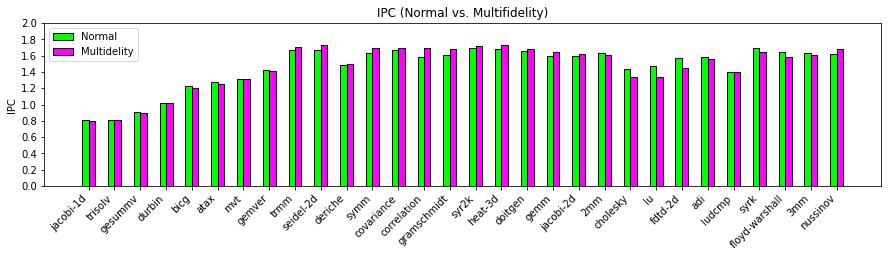

In [20]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-width/2, y_norm_ipc, width, color='lime', label='Normal', edgecolor='black')
ax.bar(x+width/2, y_mf_ipc, width, color='magenta', label='Multidelity', edgecolor='black')
#ax.bar(x+width, y_mfn_ipc, width, color='lightblue', label='Multidelity New', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,2))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 11
ax.set_yticks([(2/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
fig.savefig('plots/ipc-normal-vs-mf.png')
#plt.tight_layout()

In [16]:
pct_err = []

def p_err(approx, exact):
    return (approx-exact)/exact * 100
def mape(arr):
    return np.mean(np.absolute(arr))

print('Percent error\n')
name_len = max([len(name) for name in names])
for (i, name) in enumerate(names):
    pe = p_err(y_mf_ipc[i], y_norm_ipc[i])
    pct_err.append(pe)
    print(f'{i}'.ljust(2), f'{name}'.ljust(name_len), f'{pe: 06.2f}%')
    
print(f'\nMAPE: {mape(pct_err):.2f}%')

Percent error

0  jacobi-1d      -02.00%
1  trisolv         00.39%
2  gesummv        -01.03%
3  durbin          00.08%
4  bicg           -02.34%
5  atax           -01.53%
6  mvt             00.31%
7  gemver         -01.20%
8  trmm            02.46%
9  seidel-2d       03.12%
10 deriche         00.34%
11 symm            04.07%
12 covariance      01.50%
13 correlation     06.51%
14 gramschmidt     05.03%
15 syr2k           00.93%
16 heat-3d         03.17%
17 doitgen         01.23%
18 gemm            02.70%
19 jacobi-2d       01.27%
20 2mm            -01.46%
21 cholesky       -06.05%
22 lu             -08.84%
23 fdtd-2d        -08.01%
24 adi            -01.80%
25 ludcmp          00.41%
26 syrk           -02.58%
27 floyd-warshall -03.75%
28 3mm            -01.41%
29 nussinov        03.48%

MAPE: 2.63%


In [17]:
# Speed up calculations
mf_times_seconds = []
norm_times_seconds = []
for name in names:
    mf_times_seconds.append(mf.st[name].times.real.mean/nu.s)
    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

speedup = [((norm_times_seconds[i] / mf_times_seconds[i])) for i in range(len(names))]

print('Speedup\n')
for i in range(len(names)):
    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup[i]: 7.2f}')

print(f'\nAverage speedup: {np.mean(speedup):.2f}')

Speedup

0  jacobi-1d         1.00
1  trisolv           1.00
2  gesummv           0.95
3  durbin            0.99
4  bicg              0.97
5  atax              0.97
6  mvt               1.00
7  gemver            0.96
8  trmm              2.49
9  seidel-2d         1.92
10 deriche           1.00
11 symm              2.30
12 covariance        2.45
13 correlation       2.35
14 gramschmidt       2.39
15 syr2k             2.05
16 heat-3d           1.29
17 doitgen           2.20
18 gemm              2.07
19 jacobi-2d         2.07
20 2mm               2.25
21 cholesky          1.03
22 lu                1.03
23 fdtd-2d           1.06
24 adi               1.01
25 ludcmp            0.96
26 syrk              0.99
27 floyd-warshall    1.21
28 3mm               0.97
29 nussinov          0.93

Average speedup: 1.46


In [46]:
# Calculate speedup of the Memory simulation (subtract off Ariel time)

def mean_ariel_time(data, name):
    return np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in data.st[name].profile])

mf_times_seconds_noariel = []
norm_times_seconds_noariel = []
for name in names:
    mf_times_seconds_noariel.append(mf.st[name].times.real.mean/nu.s - mean_ariel_time(mf,name))
    norm_times_seconds_noariel.append(norm.st[name].times.real.mean/nu.s - mean_ariel_time(norm,name))

In [14]:
ariel_time = np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile])
ariel_time

1082.829858

In [9]:
print('Percent speedup without Ariel')
#TODO - also remove parrot time from norm runs

speedup_pct = [((norm_times_seconds_noariel[i] / mf_times_seconds_noariel[i])-1)*100 for i in range(len(names))]

for i, n in enumerate(names):
    print(f'{n.ljust(14)}: {speedup_pct[i]:6.02f}%')

Percent speedup without Ariel
jacobi-1d     :  -9.61%
trisolv       :  -6.21%
gesummv       :  -9.76%
durbin        :  -9.36%
bicg          :  -4.81%
atax          :  -2.53%
mvt           :  -6.88%
gemver        :  -5.18%
heat-3d       :  86.44%
ludcmp        : 131.90%
syr2k         : 136.67%
trmm          : 157.45%
correlation   : 150.52%
gramschmidt   : 149.37%
symm          : 126.56%
covariance    : 121.50%
doitgen       : 109.49%
gemm          : 116.09%
jacobi-2d     : 118.08%
floyd-warshall: 103.76%
2mm           : 121.12%
cholesky      :   0.58%
seidel-2d     :   2.76%
deriche       :   2.22%
lu            :   2.21%
adi           :   1.93%
fdtd-2d       :   2.89%
syrk          :   1.65%
3mm           :   3.42%
nussinov      :   2.13%


In [196]:
norm.st['deriche']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999            254.418   
1            memHierarchy.Bus   24576113             13.962   
2          memHierarchy.Cache  155077942            331.588   
3  memHierarchy.MemController   49999999            102.050   
4         memHierarchy.Parrot   78646625             68.045   

    avg. handler time (ns)  
0                     1272  
1                      568  
2                     2138  
3                     2041  
4                      865  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      4725089           0.436                    92
1  memHierarchy.MemLink    105901573         250.344                  2363
2   memHierarchy.Parrot    100380124          42.935                   427
Simulated time:
  2.37 (+/-0.16) ms
Wallclock Time:
  Real: 30206.85 (+/-476.47) ms
  User: 29819.93 (+/-

In [197]:
[np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile]

[477.159364, 478.199233, 472.19425700000005, 458.189289, 468.041158]

In [274]:
mf.st['2mm']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999           1175.339   
1            memHierarchy.Bus    8446518             13.142   
2          memHierarchy.Cache   39507364            308.108   
3  memHierarchy.MemController   49999999            121.382   
4         memHierarchy.Parrot  145400710            315.106   

    avg. handler time (ns)  
0                     5876  
1                     1555  
2                     7798  
3                     2427  
4                     2167  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      2162912           0.579                   267
1  memHierarchy.MemLink    108949898         651.677                  5981
2   memHierarchy.Parrot    187950003         257.391                  1369
Simulated time:
  23067.82 (+/-0.00) ms
Wallclock Time:
  Real: 676904356.15 (+/-0.00) ms
  User: 6671120